In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv("https://raw.githubusercontent.com/Gideon-Muazu/Time_series_Dataset/main/Time_series_analysis_and_forecast_DATASET.csv")

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92016 entries, 0 to 92015
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   FullDate   92016 non-null  object 
 1   Tmax       92016 non-null  float64
 2   SysLoad    92016 non-null  float64
 3   GasPrice   92016 non-null  float64
 4   ElecPrice  92016 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.5+ MB


In [4]:
df.head()

,FullDate,Tmax,SysLoad,GasPrice,ElecPrice
0,2010-09-01 00:00:00,15.8,1688.215,3.69,23.710
1,2010-09-01 01:00:00,15.8,1669.195,3.69,22.635
2,2010-09-01 02:00:00,15.8,1491.980,3.69,22.565
3,2010-09-01 03:00:00,15.8,1330.760,3.69,18.910
4,2010-09-01 04:00:00,15.8,1247.940,3.69,18.030


In [5]:
df.isna().sum()

FullDate     0
Tmax         0
SysLoad      0
GasPrice     0
ElecPrice    0
dtype: int64

Text(0, 0.5, 'ElecPrice')

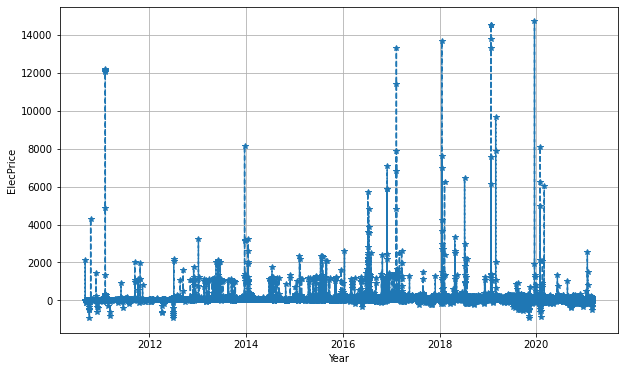

In [6]:
#Conversion to date_time
df["FullDate"] = pd.to_datetime(df["FullDate"])   #convert column to date
df.set_index("FullDate", inplace=True)
plt.figure(figsize=(10,6))
plt.plot(df.index, df.ElecPrice, '--', marker='*', )
plt.grid()
plt.xlabel('Year')
plt.ylabel('ElecPrice')

In [7]:
#downsampling data to daily data points
df_daily = df.resample('D').sum()
df_daily.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3834 entries, 2010-09-01 to 2021-02-28
Freq: D
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Tmax       3834 non-null   float64
 1   SysLoad    3834 non-null   float64
 2   GasPrice   3834 non-null   float64
 3   ElecPrice  3834 non-null   float64
dtypes: float64(4)
memory usage: 149.8 KB


Text(0, 0.5, 'Daily active power')

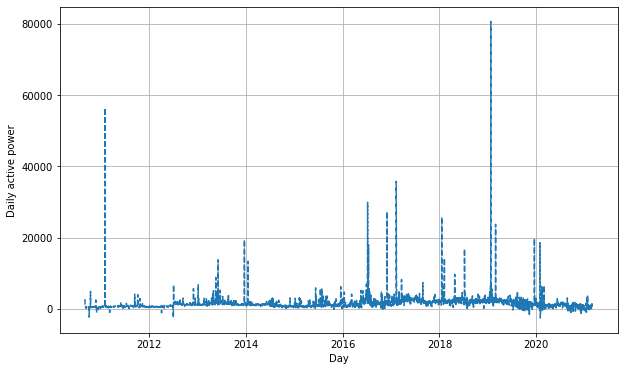

In [8]:
#plot of the daily global active power over time
plt.figure(figsize=(10,6))
plt.plot(df_daily.index, df_daily.ElecPrice, '--')
plt.grid()
plt.xlabel('Day')
plt.ylabel('Daily active power')

In [9]:
from statsmodels.tsa.stattools import adfuller

In [10]:
adf_result = adfuller(df_daily['SysLoad'])
print(f'p-value: {round(adf_result[1],6)}')

p-value: 0.004254


In [11]:
adf_result = adfuller(df_daily['GasPrice'])
print(f'p-value: {round(adf_result[1],6)}')

p-value: 0.045027


In [12]:
adf_result = adfuller(df_daily['GasPrice'])
print('Critical Values:')
for k, v in adf_result[4].items():
  print(f'{k} : {v}')

Critical Values:
1% : -3.4320693157877544
5% : -2.8622996992165364
10% : -2.5671743978048323


In [13]:
adf_result = adfuller(df_daily['ElecPrice'])
print('Critical values:')
for k, v in adf_result[4].items():
  print(f'{k} : {v}')

Critical values:
1% : -3.432066157296446
5% : -2.8622983040036005
10% : -2.5671736550459663


In [14]:
#resetting the index
df_daily = df_daily.reset_index()
df_daily.head()

,FullDate,Tmax,SysLoad,GasPrice,ElecPrice
0,2010-09-01,379.2,41565.380,88.56,2751.700
1,2010-09-02,369.6,38898.990,88.56,570.810
2,2010-09-03,439.2,41665.760,106.80,504.975
3,2010-09-04,328.8,35638.085,81.36,502.275
4,2010-09-05,357.6,35611.410,106.80,500.555


In [15]:
# selecting columns for prediction model
model_df = df_daily[['FullDate', 'ElecPrice']]

#renaming of columns to 'ds' and 'y' respectively
model_data = model_df.rename(columns={'FullDate':'ds', 'ElecPrice':'y'})

In [16]:
#Train-Test split of the dataset
train = model_data[:2757]
test = model_data[2757:]
print('train shape', train.shape)
print('test shape', test.shape)

train shape (2757, 2)
test shape (1077, 2)


In [17]:
#fitting of the train data to fbprophet model
from prophet import Prophet
model = Prophet()
model.fit(train) 

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpld97x4n9/7172193v.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpld97x4n9/ctt2vkqp.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=18899', 'data', 'file=/tmp/tmpld97x4n9/7172193v.json', 'init=/tmp/tmpld97x4n9/ctt2vkqp.json', 'output', 'file=/tmp/tmpld97x4n9/prophet_modelb74n1dy5/prophet_model-20230130152746.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
15:27:46 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
15:27:47 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [40]:
# Make Predictions
future = model.make_future_dataframe(periods=len(test), freq='D')
forecast = model.predict(test)
forecast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2018-03-20,2684.565824,116.764093,4893.934658,2684.565824,2684.565824,-155.040628,-155.040628,-155.040628,9.737379,9.737379,9.737379,-164.778008,-164.778008,-164.778008,0.0,0.0,0.0,2529.525196
1,2018-03-21,2685.359782,257.903971,4935.695501,2685.359782,2685.359782,-2.567491,-2.567491,-2.567491,159.353195,159.353195,159.353195,-161.920686,-161.920686,-161.920686,0.0,0.0,0.0,2682.792291
2,2018-03-22,2686.153740,213.784670,5034.896295,2686.153740,2686.153740,95.607310,95.607310,95.607310,257.107547,257.107547,257.107547,-161.500237,-161.500237,-161.500237,0.0,0.0,0.0,2781.761050
3,2018-03-23,2686.947698,323.569556,5085.873742,2686.947698,2686.947698,-113.077820,-113.077820,-113.077820,50.273097,50.273097,50.273097,-163.350918,-163.350918,-163.350918,0.0,0.0,0.0,2573.869878
4,2018-03-24,2687.741656,-43.877238,4531.040973,2687.741656,2687.741656,-438.673661,-438.673661,-438.673661,-271.443120,-271.443120,-271.443120,-167.230541,-167.230541,-167.230541,0.0,0.0,0.0,2249.067995


In [41]:
#yhat is the prediction while yhat_lower and yhat_upper are the upper and lower boundaries
forecast[['ds','yhat','yhat_lower','yhat_upper','trend', 'trend_lower', 'trend_upper']]

,ds,yhat,yhat_lower,yhat_upper,trend,trend_lower,trend_upper
0,2018-03-20,2529.525196,116.764093,4893.934658,2684.565824,2684.565824,2684.565824
1,2018-03-21,2682.792291,257.903971,4935.695501,2685.359782,2685.359782,2685.359782
2,2018-03-22,2781.761050,213.784670,5034.896295,2686.153740,2686.153740,2686.153740
3,2018-03-23,2573.869878,323.569556,5085.873742,2686.947698,2686.947698,2686.947698
4,2018-03-24,2249.067995,-43.877238,4531.040973,2687.741656,2687.741656,2687.741656
...,...,...,...,...,...,...,...
1072,2021-02-24,3446.060747,498.482413,6363.982275,3535.688715,1816.077995,5340.744051
1073,2021-02-25,3512.928139,502.367130,6639.038099,3536.482672,1814.821029,5344.672973
1074,2021-02-26,3279.749616,412.683136,6251.553941,3537.276630,1813.564063,5348.601894
1075,2021-02-27,2936.426367,85.997389,5941.367818,3538.070588,1812.184947,5352.530816


In [42]:
#Evaluation of model performance
from sklearn.metrics import mean_squared_error

def mape(test, forecast):
  mape = np.mean(np.abs(np.array(test['y']) - np.array(forecast['yhat']))/ np.array(test['y'])) *100
  rmse = np.sqrt(mean_squared_error(np.array(test['y']), np.array(forecast['yhat'])))
  return f'mape value is: {round(mape,2)} and rmse value is: {round(rmse,2)}'

In [43]:
mape(test, forecast)

'mape value is: -133.47 and rmse value is: 3208.06'

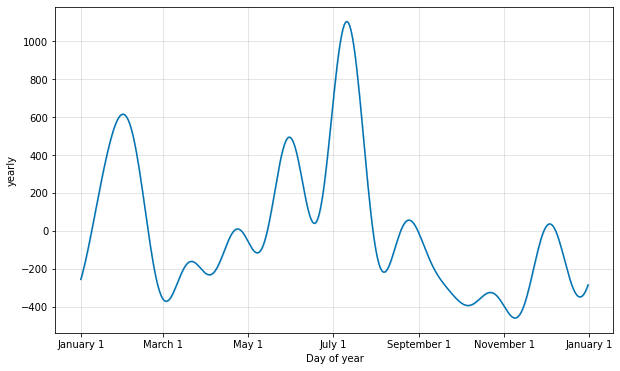

In [22]:
from prophet.plot import plot_yearly
plot_yearly(model)

In [23]:
multi_model = df_daily.rename(columns = {'FullDate':'ds','ElecPrice':'y',
                                         'SysLoad':'add1',
                                         'Tmax':'add2',
                                         'GasPrice':'add3'})
multi_model.head()

,ds,add2,add1,add3,y
0,2010-09-01,379.2,41565.380,88.56,2751.700
1,2010-09-02,369.6,38898.990,88.56,570.810
2,2010-09-03,439.2,41665.760,106.80,504.975
3,2010-09-04,328.8,35638.085,81.36,502.275
4,2010-09-05,357.6,35611.410,106.80,500.555


In [24]:
# assign train and test data
train2 = multi_model[:2757]
test2 = multi_model[2757:]
print('train shape', train2.shape)
print('test shape', test2.shape)

train shape (2757, 5)
test shape (1077, 5)


In [25]:
#create multivariate model
model2 = Prophet()
model2.add_regressor('add1')
model2.add_regressor('add2')
model2.add_regressor('add3')

In [26]:
model2.fit(train2)

forecast2 = model2.predict(test2)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpld97x4n9/oe0qlnf2.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpld97x4n9/ogn0nb4g.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=75144', 'data', 'file=/tmp/tmpld97x4n9/oe0qlnf2.json', 'init=/tmp/tmpld97x4n9/ogn0nb4g.json', 'output', 'file=/tmp/tmpld97x4n9/prophet_modelri2vpk53/prophet_model-20230130152748.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
15:27:48 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
15:27:48 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [27]:
forecast2

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,add1,add1_lower,add1_upper,add2,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2018-03-20,1867.204510,-131.002161,4311.676572,1867.204510,1867.204510,-856.286567,-856.286567,-856.286567,0.236280,...,-84.476147,-84.476147,-84.476147,-39.061079,-39.061079,-39.061079,0.0,0.0,0.0,1986.764063
1,2018-03-21,1867.893046,-298.007260,4342.311550,1867.893046,1867.893046,-1026.281456,-1026.281456,-1026.281456,0.233477,...,42.524741,42.524741,42.524741,-29.773204,-29.773204,-29.773204,0.0,0.0,0.0,1978.166932
2,2018-03-22,1868.581583,732.818332,5109.531106,1868.581583,1868.581583,-214.935967,-214.935967,-214.935967,0.219893,...,145.612882,145.612882,145.612882,-24.740713,-24.740713,-24.740713,0.0,0.0,0.0,2898.308005
3,2018-03-23,1869.270119,512.188422,4846.526802,1869.270119,1869.270119,-274.867855,-274.867855,-274.867855,0.211915,...,-44.306399,-44.306399,-44.306399,-23.822245,-23.822245,-23.822245,0.0,0.0,0.0,2582.549267
4,2018-03-24,1869.958655,-825.449313,3709.256642,1869.958655,1869.958655,-1076.321337,-1076.321337,-1076.321337,0.209975,...,-117.531858,-117.531858,-117.531858,-26.767060,-26.767060,-26.767060,0.0,0.0,0.0,1435.761426
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1072,2021-02-24,2605.315322,-1502.577700,3213.730323,1868.978053,3315.061718,-1372.192578,-1372.192578,-1372.192578,0.236495,...,42.524741,42.524741,42.524741,-433.744132,-433.744132,-433.744132,0.0,0.0,0.0,957.503898
1073,2021-02-25,2606.003858,-908.999891,3671.621844,1868.572129,3316.034917,-1032.937260,-1032.937260,-1032.937260,0.238220,...,145.612882,145.612882,145.612882,-460.171529,-460.171529,-460.171529,0.0,0.0,0.0,1317.075756
1074,2021-02-26,2606.692394,-844.350088,3728.740810,1868.166204,3317.008116,-754.468564,-754.468564,-754.468564,0.235633,...,-44.306399,-44.306399,-44.306399,-480.828796,-480.828796,-480.828796,0.0,0.0,0.0,1380.909766
1075,2021-02-27,2607.380931,-1477.415350,3293.825100,1867.760280,3317.981315,-1010.907808,-1010.907808,-1010.907808,0.234124,...,-117.531858,-117.531858,-117.531858,-495.478359,-495.478359,-495.478359,0.0,0.0,0.0,1035.806590


In [28]:
def mape_2(test2,forecast2):
  mape2 = np.mean(np.abs(np.array(test2['y']) - np.array(forecast2.yhat))/ np.array(test2['y'])) *100
  rmse2 = np.sqrt(mean_squared_error(np.array(test2['y']),np.array(forecast2['yhat'])))
  return f'mape value is: {round(mape2,2)} and rmse value is: {round(rmse2,2)}'

In [29]:
mape_2(test2,forecast2)

'mape value is: -63.32 and rmse value is: 2707.61'

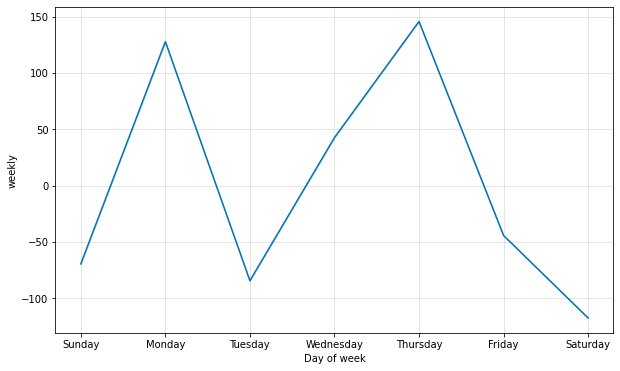

In [30]:
# visualizing each components
from prophet.plot import plot_weekly
plot_weekly(model2)

In [31]:
multi_model_2 = df_daily.rename(columns = {'FullDate':'ds','ElecPrice':'y','SysLoad':'add1','GasPrice':'add2'})
multi_model_2.drop('Tmax', axis=1,inplace=True)

In [32]:
multi_model_2

,ds,add1,add2,y
0,2010-09-01,41565.38000,88.5600,2751.700
1,2010-09-02,38898.99000,88.5600,570.810
2,2010-09-03,41665.76000,106.8000,504.975
3,2010-09-04,35638.08500,81.3600,502.275
4,2010-09-05,35611.41000,106.8000,500.555
...,...,...,...,...
3829,2021-02-24,-1525.49745,134.4000,634.770
3830,2021-02-25,4539.07855,130.5048,577.515
3831,2021-02-26,9517.02430,130.1808,1445.495
3832,2021-02-27,4932.88015,130.0800,488.980


In [33]:
# assign train and test data
train3 = multi_model_2[:2757]
test3 = multi_model_2[2757:]
print('train shape', train3.shape)
print('test shape', test3.shape)
train3

train shape (2757, 4)
test shape (1077, 4)


,ds,add1,add2,y
0,2010-09-01,41565.38000,88.5600,2751.700
1,2010-09-02,38898.99000,88.5600,570.810
2,2010-09-03,41665.76000,106.8000,504.975
3,2010-09-04,35638.08500,81.3600,502.275
4,2010-09-05,35611.41000,106.8000,500.555
...,...,...,...,...
2752,2018-03-15,27139.02585,220.6272,2717.340
2753,2018-03-16,19710.46400,216.9600,2277.335
2754,2018-03-17,1079.34705,209.0400,1718.385
2755,2018-03-18,-4102.43795,203.9880,1088.015


In [34]:
# Creation of Multivariate model
model3 = Prophet()
model3.add_regressor('add1')
model3.add_regressor('add2')

In [35]:
model3.fit(train3)

forecast3 = model3.predict(test3)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpld97x4n9/8ibxntgt.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpld97x4n9/2f9fsgj5.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=81671', 'data', 'file=/tmp/tmpld97x4n9/8ibxntgt.json', 'init=/tmp/tmpld97x4n9/2f9fsgj5.json', 'output', 'file=/tmp/tmpld97x4n9/prophet_modelsyna2ucx/prophet_model-20230130152750.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
15:27:50 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
15:27:50 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [36]:
def mape_3(test3,forecast3):
  mape3 = np.mean(np.abs(np.array(test3['y']) - np.array(forecast3.yhat))/ np.array(test3['y'])) *100
  # rmse2 = np.sqrt(mean_squared_error(np.array(test2['y']),np.array(forecast2['yhat'])))
  return f'mape value is: {round(mape3,2)}'


In [37]:
mape_3(test3,forecast3)

'mape value is: -63.92'